# lissajous fill curve

In [3]:
from matplotlib import pyplot as plt
import numpy as np

In [4]:
def ift(t,a,f=None):
  n=len(a)
  n_2=n//2
  if f is None:
    f=np.roll(np.arange(-n_2,n-n_2),n-n_2)
  f=f.reshape((-1,1))
  return np.sum(a.reshape((-1,1))*np.exp(1j*2*np.pi*f*t),axis=0)/n

(9.294559016897017-0.38955744302099343j)


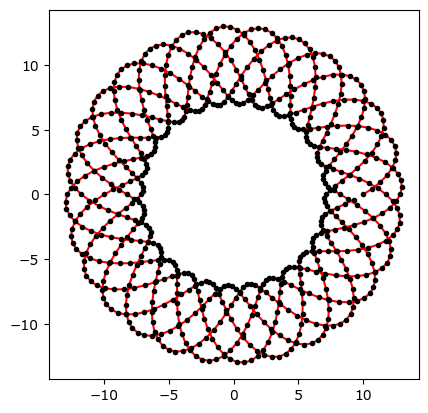

In [39]:
n=5
f1,f2=5,5*n+3
a1,a2=10,3
t=np.arange(0,1,1/750)
a=a1+a2*np.sin(f2*2*np.pi*t)
x=a*np.exp(1j*2*np.pi*5*t)
plt.gca().set_aspect('equal')
plt.plot(x.real,x.imag,'r-');
plt.plot(x.real,x.imag,'k.');
print(x[-1])

In [2]:
def hullVertices(p,tol=None):
    if tol==None:tol=0 # do not consider points closer than "tol" to the existing hull as new hull point
    def hv(vl,vr,vs):
        dv=p[vr]-p[vl]
        if (len(vs)==0) or (dv==0): 
            return
        rotps=(p[vs]-p[vl])*(abs(dv)/dv)
        vmin=np.argmin(rotps.imag)
        vsmin=vs[vmin]
        if vl==vsmin or vr==vsmin:
            return
        if rotps[vmin].imag>= -tol:#concave point 
            return
        rotps_imag_negative=(rotps.imag< -tol)#only consider points to the right of vl -> vr 
        yield from hv(vl,vsmin,vs[(rotps.real<rotps[vmin].real)&rotps_imag_negative])
        yield vsmin
        yield from hv(vsmin,vr,vs[(rotps.real>rotps[vmin].real)&rotps_imag_negative]) 
    vmin=np.argmin(p.real)
    vmax=np.argmax(p.real)
    if p[vmin].real == p[vmax].real:#real parts are all the same. 
      vmin=np.argmin(p.imag)
      vmax=np.argmax(p.imag)
    allvs=np.arange(len(p),dtype=int)
    yield vmax
    yield from hv(vmax,vmin,allvs)
    yield vmin
    yield from hv(vmin,vmax,allvs) 

In [5]:
def hull2Segments(p):
  p1=np.roll(p,-1)
  dp=p1-p
  l=abs(dp)
  udp=dp/l#unit vector
  a=np.log(np.roll(udp,-1)/udp).imag
  for l,a in zip(l,a):
      yield (l,0)
      yield (0,a)

In [6]:
from cmath import exp,pi
def Segments2Complex(Segs,p0=0+0j,scale=1.0,a0=1+0j,tol=0.05,offs=0,loops=1,return_heading=False):
  """
  The parameter "tol defines the resolution. It is the maximum allowable
  difference between circular arc segment, and the secant between the
  calculated points on the arc. Smaller values for tol will result in
  more points per segment.
  """
  a=a0/abs(a0)
  p=p0
  p-=1j*a*offs
  for _ in range(loops):
      for l,da in Segs:
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for _ in range(n):
          p+=v
          if return_heading:
            yield p,a
          else:
            yield p
          v*=dda
          a*=dda

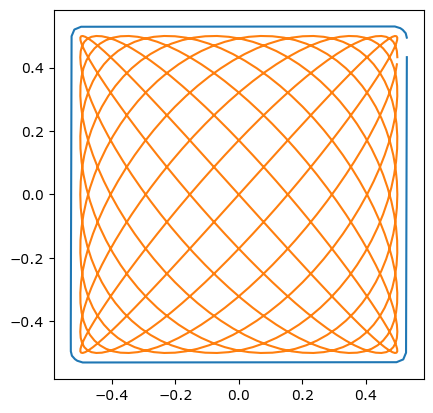

In [7]:
hull=np.array(x[list(hullVertices(x,tol=0.003))])
hs=list(hull2Segments(hull))
p0,p1=hull[:2]
offs_hull=np.array(list(Segments2Complex(hs,p0=p0,a0=p1-p0,offs=0.03,tol=0.003)))
plt.gca().set_aspect('equal')
#plt.plot(hull.real,hull.imag);
plt.plot(offs_hull.real,offs_hull.imag)
plt.plot(x.real,x.imag);

In [8]:
if 'google.colab' in str(get_ipython()):
  try:
    import fullcontrol as fc
  except Exception as e:
    print (e)
    print('Attempting to install missing packages. Please wait ...')
    !pip install git+https://github.com/FullControlXYZ/fullcontrol --quiet
    import fullcontrol as fc
  from google.colab import files

In [9]:
# create design steps

# print part:
steps=[]
scale=40
hl=0.2
ew=0.75
n=len(x)
dzdj=hl/n
j=0
zt=10
zb=0
eh_min=hl/2
steps.append(fc.Extruder(on=False))
steps.extend(fc.travel_to(fc.Point(x=offs_hull[-1].real*scale,y=offs_hull[-1].imag*scale,z=hl)))
steps.append(fc.ExtrusionGeometry(area_model='rectangle',width=1,height=hl))
steps.append(fc.Extruder(on=True))
for p in offs_hull:
  steps.append(fc.Point(x=p.real*scale,y=p.imag*scale))
z=zb+eh_min
steps.extend(fc.travel_to(fc.Point(x=x[-1].real*scale,y=x[-1].imag*scale)))
steps.extend(fc.travel_to(fc.Point(z=z)))
steps.append(fc.Extruder(on=True))
old_eh=-1
while z<zt+hl:
  j=(j+1)%n
  z+=dzdj
  p=x[j]
  eh=min(z-zb if z<zb+hl+eh_min else hl,zt-(z-hl))
  if abs(eh-old_eh)>0.01:
    steps.append(fc.ExtrusionGeometry(area_model='rectangle',width=ew,height=eh))
    old_eh=eh
 #   print(f'{z=:0.3f}, {eh=:0.3f}')
  steps.append(fc.Point(x=p.real*scale,y=p.imag*scale,z=min(z,zt)))
steps.append(fc.Extruder(on=False))
steps.extend(fc.travel_to(fc.Point(x=12,y=12)))
# offset the whole procedure. z dictates the gap between the nozzle and the bed for the first layer, assuming the model was designed with a first layer z-position of 0
steps = fc.move(steps,fc.Point(x=100,y=100,z=0.0))

NameError: name 'fc' is not defined

In [ ]:
# add annotations and plot
EW=0.5
EH=0.2
annotations = []
#annotations.append(fc.PlotAnnotation(point=steps[0], label = "Start"))
#annotations.append(fc.PlotAnnotation(point=steps[-1], label = "End"))
fc.transform(steps + annotations, 'plot', fc.PlotControls(color_type='print_sequence' ,initialization_data={'extrusion_width': EW, 'extrusion_height': EH}))

In [ ]:
design_name = 'lissajous'
nozzle_temp = 220
bed_temp = 120
print_speed = 30*60
fan_percent = 0
EH = 0.2    # extrusion heigth
EW = 0.5    # extrusion width
printer_name = 'generic'
#printer_name = 'Prusa_Mendel'
gcode_controls = fc.GcodeControls(
    printer_name=printer_name,
    save_as=design_name,
    initialization_data={
        'primer': 'no_primer',
        'print_speed': print_speed,
        'nozzle_temp': nozzle_temp,
        'bed_temp': bed_temp,
        'fan_speed':fan_percent,
         })
gcode = fc.transform(steps, 'gcode', gcode_controls)